# PhiFlow Assignment

## 1. Defining new geometries
Please have a look at 

In [1]:
%load_ext autoreload
%autoreload 2
from phi.torch.flow import *
from typing import Union

In [9]:
class Triangle(Geometry):
    def __init__(self, *points):
        # Points given in counter-clockwise order with vertex dimension
        if len(points) == 3:
            self._points = math.stack(points, instance('vertex'))
        else:
            assert len(points) == 1
            assert 'vertex' in points[0].shape
            self._points = points[0]
        print(self._points)
        self.vec1 = self._points.vertex[1] - self._points.vertex[0]
        self.vec2 = self._points.vertex[2] - self._points.vertex[0]

    @property
    def shape(self):
        return self._points.shape.without('vertex')
    
    @property
    def volume(self):
        return math.cross_product(self.vec1, self.vec2) / 2
    
    @property
    def shape_type(self) -> Tensor:
        return math.tensor('T')

    def __variable_attrs__(self):
        return '_points',
    
    def lies_inside(self, location):
        # Barycentric coordinates
        # https://gamedev.stackexchange.com/questions/23743/whats-the-most-efficient-way-to-find-barycentric-coordinates
        # https://en.wikipedia.org/wiki/Barycentric_coordinate_system
        v0 = self.vec2
        v1 = self.vec1
        v2 = location - self._points.vertex[0]
        dot00 = math.dot(v0, 'vector', v0, 'vector')
        dot01 = math.dot(v0, 'vector', v1, 'vector')
        dot02 = math.dot(v0, 'vector', v2, 'vector')
        dot11 = math.dot(v1, 'vector', v1, 'vector')
        dot12 = math.dot(v1, 'vector', v2, 'vector')
        invDenom = 1 / (dot00 * dot11 - dot01 * dot01)
        u = (dot11 * dot02 - dot01 * dot12) * invDenom
        v = (dot00 * dot12 - dot01 * dot02) * invDenom
        return (u >= 0) & (v >= 0) & (u + v < 1)

    @property
    def center(self) -> Tensor:
        return math.mean(self._points, 'vertex')

    def bounding_radius(self) -> Tensor:
        return math.max(math.vec_length(self._points - self.center), 'vertex')

    def bounding_half_extent(self) -> Tensor:
        return math.max(math.abs(self._points - self.center), 'vertex')
    
    @staticmethod
    def _distance_line_seg_to_point(A, B, P):
        on_point = math.all(A == P, 'vector') | math.all(B == P, 'vector')

        past_line_toward_A =\
            math.arccos(math.dot((P - A) / math.vec_length(P - A), 'vector',
                                 (B - A) / math.vec_length(B - A), 'vector')) > math.PI / 2
        past_line_toward_B =\
            math.arccos(math.dot((P - B) / math.vec_length(P - B), 'vector',
                                 (A - B) / math.vec_length(A - B), 'vector')) > math.PI / 2
        
        # Outer has highest priority
        distances = math.where(on_point,
                        value_true=0,
                        value_false=math.where(past_line_toward_A,
                            value_true=math.vec_length(P - A),
                            value_false=math.where(past_line_toward_B,
                                    value_true=math.vec_length(P - B),
                                    value_false=math.vec_length(math.cross_product(P - A, P - B)) / math.vec_length(B - A))))
        return distances

    
    def approximate_signed_distance(self, location: Union[Tensor, tuple]) -> Tensor:
        As = self._points
        Bs = math.stack((self._points.vertex[1], self._points.vertex[2], self._points.vertex[0]), instance('vertex'))
        dist = self._distance_line_seg_to_point(A=As, B=Bs, P=location)
        min_dist = math.min(dist, 'vertex') * math.where(self.lies_inside(location), value_true=-1, value_false=1)
        return min_dist

(x=0.000, y=20.000); (x=40.000, y=70.000); (x=0.000, y=70.000) (vertexⁱ=3, vectorᶜ=x,y)
(x=100.000, y=20.000); (x=100.000, y=70.000); (x=60.000, y=70.000) (vertexⁱ=3, vectorᶜ=x,y)
(Obstacle(geometry=Triangle(vectorᶜ=x,y), velocity=(x=0.000, y=0.000) float64, angular_velocity=0.0), Obstacle(geometry=Triangle(vectorᶜ=x,y), velocity=(x=0.000, y=0.000) float64, angular_velocity=0.0), Obstacle(geometry=Box(x=(0.0, 40.0), y=(70.0, 100.0)), velocity=(x=0.000, y=0.000) float64, angular_velocity=0.0), Obstacle(geometry=Box(x=(60.0, 100.0), y=(70.0, 100.0)), velocity=(x=0.000, y=0.000) float64, angular_velocity=0.0))


  0%|          | 0/100 [00:00<?, ?it/s]

CenteredGrid[(xˢ=25, vectorᶜ=x,y), size=(x=100.000), extrapolation={'x': (boundary, boundary), 'y': (boundary, 0)}]
(x=-0.125, y=409600.375) (x=-1.000, y=3276803.000)


(x=102.516, y=167764279296.000)

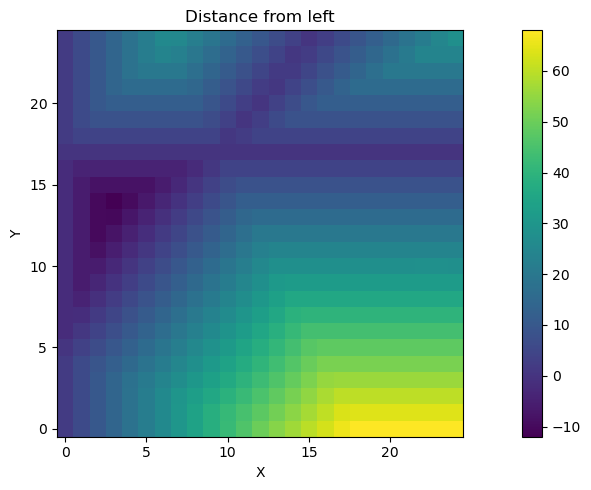

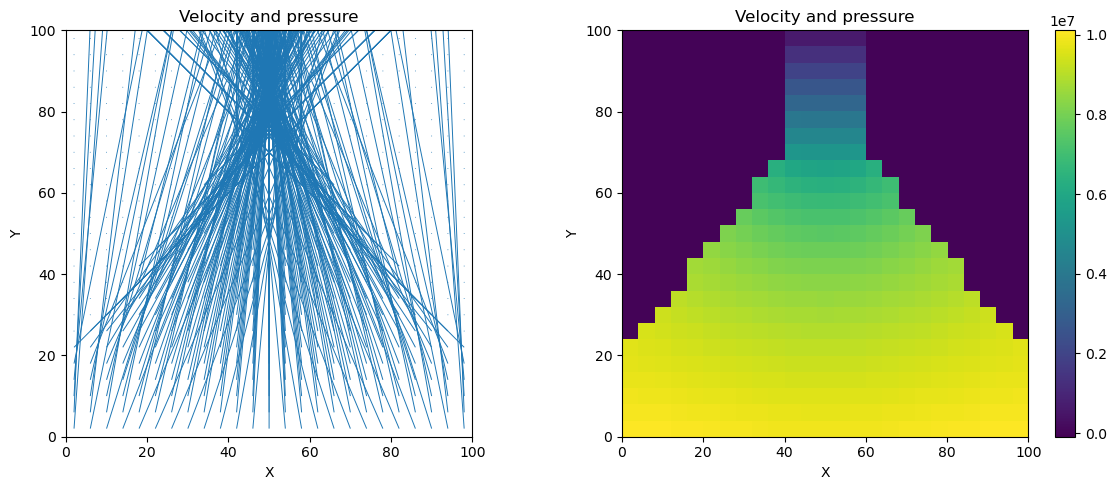

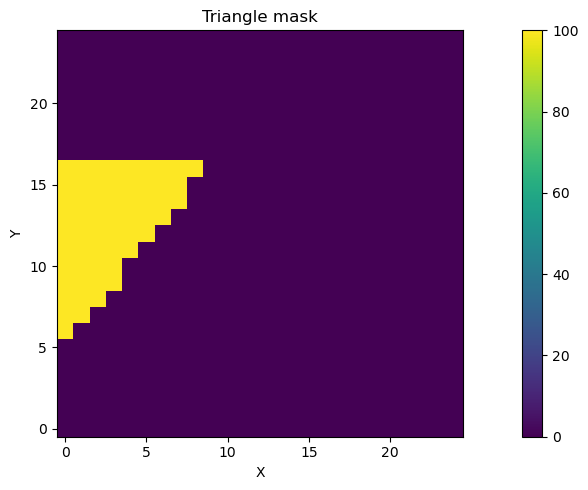

In [13]:
from tqdm.auto import tqdm, trange
triangle1 = Obstacle(Triangle(
    math.tensor([[0., 20.], [40., 70.], [0., 70.]], instance('vertex'), channel(vector='x,y'))
))
triangle2 = Obstacle(Triangle(
    math.tensor([[100., 20.], [100., 70.], [60., 70.]], instance('vertex'), channel(vector='x,y'))
))
box1 = Obstacle(Box(lower=math.tensor([0., 70.], channel(vector='x,y')), upper=math.tensor([40., 100.], channel(vector='x,y'))))
box2 = Obstacle(Box(lower=math.tensor([60., 70.], channel(vector='x,y')), upper=math.tensor([100., 100.], channel(vector='x,y'))))

OBSTACLES = (triangle1, triangle2, box1, box2)
print(OBSTACLES)

# Define the domain and velocity field
DOMAIN = dict(x=25, y=25, bounds=Box(x=100, y=100))
grid = CenteredGrid(0, **DOMAIN)
pos = grid.elements.center
distance = triangle1.geometry.approximate_signed_distance(pos)

plot(distance, title='Distance from left')

goal_velocity = 10.0

def simulate(initial_y_speed):
    velocity = StaggeredGrid(0, extrapolation.combine_sides(x=extrapolation.ZERO,
                             y=(extrapolation.ConstantExtrapolation(math.tensor(np.array([0., initial_y_speed]), channel(vector='x,y'), convert=False)),
                                extrapolation.ZERO_GRADIENT)), **DOMAIN)

    @jit_compile(forget_traces=True)
    def step(velocity):
        velocity = advect.semi_lagrangian(velocity, velocity, 0.01)
        velocity, pressure = fluid.make_incompressible(velocity, OBSTACLES, )
        # fluid.masked_laplace.tracers.clear()  # we will need to retrace because the matrix changes each step. This is not needed when JIT-compiling the physics.
        return velocity, pressure

    pressure = None
    for i in trange(100):
        velocity, pressure = step(velocity)

    triangle_mask = (OBSTACLES[0].geometry.approximate_signed_distance(pressure.elements.center) < 0) * 100.
    plot(velocity, pressure, title='Velocity and pressure')
    plot(triangle_mask, title='Triangle mask')

    # Integrate over bottleneck velocity at the end
    dL = pressure.dx
    bottleneck: CenteredGrid = field.resample(velocity, pressure).y[9] * dL
    print(bottleneck)
    bottleneck_flow = math.sum(bottleneck.values, 'x')
    average_velocity = (bottleneck_flow / (bottleneck_flow.shape.size * dL))[{'channel': 'y'}]
    print(average_velocity, bottleneck_flow)
    return math.sum((average_velocity - goal_velocity) ** 2, 'channel')


# with jax.checking_leaks():
simulate(1.0)



